# Testing implementación RIGOL MSO2102A

A partir de 8 test se verofican:

- Comunicación SCPI funcional
- RUN/STOP, escalas, trigger
- Modos de adquisición
- Lectura y graficado de forma de onda
- Secuencia automática integrada

## TEST 1 – Conexión y comunicación básica

Se muestra abre la conexión y muestra la información técnica del equipo: fabricante, modelo, etc.

In [1]:
from oscrigol import Oscrigol

# Crear objeto y conectar
scope = Oscrigol("192.168.2.2")
scope.initComm()

# Verificar identificación
print("Identificación del equipo:", scope.getID())

# Cerrar conexión
scope.closeComm()


Identificación del equipo: RIGOL TECHNOLOGIES,MSO2102A,DS2F214100395,00.03.06



## TEST 2 – Comandos de ejecución: RUN / STOP

La pantalla del RIGOL debería congelarse y luego reanudar movimiento.

In [2]:
import time

# Abrir conexión
scope.initComm()

# Detener adquisición
scope.stop()
print("Estado: Pantalla congelada y botón RUN/STOP en ROJO")

# Delay 5 segundos
print("Delay 5 segundos....")
time.sleep(5)

# Iniciar adquisición
scope.run()
print("Estado: Señal vuelve a actualizarse y botón RUN/STOP en VERDE")

# Cerrar conexión
scope.closeComm()

Estado: Pantalla congelada y botón RUN/STOP en ROJO
Delay 5 segundos....
Estado: Señal vuelve a actualizarse y botón RUN/STOP en VERDE


## TEST 3 – Escala vertical y horizontal

La escala vertical del CH1 cambia en pantalla.

El eje horizontal se ajusta a 1 ms/div.

In [3]:
# Abrir conexión
scope.initComm()

# Ajustar escala vertical del canal 1
scope.setVertScale(channel=1, vScale=0.5)
print("Escala vertical (CH1) actual:", scope.getVertScale(1), "V/div")

# Ajustar escala horizontal (base de tiempo)
time_scale = 1e-3 # 1 ms
scope.setHScale(horizontalScale=time_scale)
print(f"Base de tiempo ajustada a {time_scale*1e3} ms/div")

# Cerrar conexión
scope.closeComm()

Escala vertical (CH1) actual: 0.5 V/div
Base de tiempo ajustada a 1.0 ms/div


## TEST 4 – Configuración de trigger

La línea de trigger se mueve a 0 V.

In [4]:
# Abrir conexión
scope.initComm()

# Configurar trigger en canal 1, flanco positivo, acoplamiento DC
scope.setEdgeTrigger(source="CHAN1", slope="POS", coupling="DC", level=0.0)
print("Trigger configurado en flanco positivo, nivel 0 V")

# Cerrar conexión
scope.closeComm()

Trigger configurado en flanco positivo, nivel 0 V


## TEST 5 – Modos de adquisición

El osciloscopio cambia a “Average 4” en la barra superior.
La forma de onda se suaviza.

In [5]:
scope.initComm()

# Modo Sample (normal)
scope.setSampAcquisition()
print("Modo de adquisición: SAMPLE")

time.sleep(2)

# Modo Average (4 promedios)
scope.setAvgAcquisition(4)
print("Modo de adquisición: AVERAGE (4)")

scope.closeComm()

Modo de adquisición: SAMPLE
Modo de adquisición: AVERAGE (4)


## TEST 6 – Adquisición y lectura de datos

Obtener una curva correspondiente a la señal del CH1 (por ejemplo, una onda cuadrada de la salida de prueba).

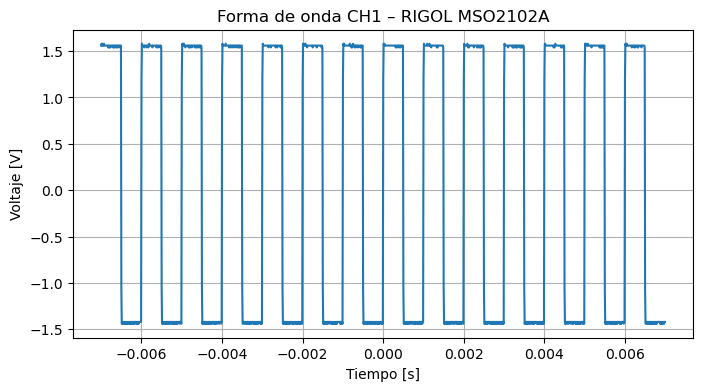

In [6]:
import matplotlib.pyplot as plt
import numpy as np

scope.initComm()

# Detener adquisición y leer datos de canal 1
scope.stop()
t = scope.getHorValues(channel=1)
v = scope.getVertValues(channel=1)

scope.run()
scope.closeComm()

# Graficar
plt.figure(figsize=(8,4))
plt.plot(t, v)
plt.title("Forma de onda CH1 – RIGOL MSO2102A")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.grid(True)
plt.show()


## TEST 7 – Mostrar/Ocultar canal

El canal 2 desaparece del display y luego vuelve a mostrarse.

In [7]:
scope.initComm()

# Ocultar canal 2
scope.hideChannel(2)
print("Canal 2 oculto")

time.sleep(2)

# Mostrar canal 2
scope.showChannel(2)
print("Canal 2 visible nuevamente")

scope.closeComm()

Canal 2 oculto
Canal 2 visible nuevamente


## TEST 8 – Adquisición completa usando `__call__()`

Mismo resultado que en el Test 6, pero ahora automatizado (usa la lógica interna de la clase).

Datos adquiridos: (2, 1400)


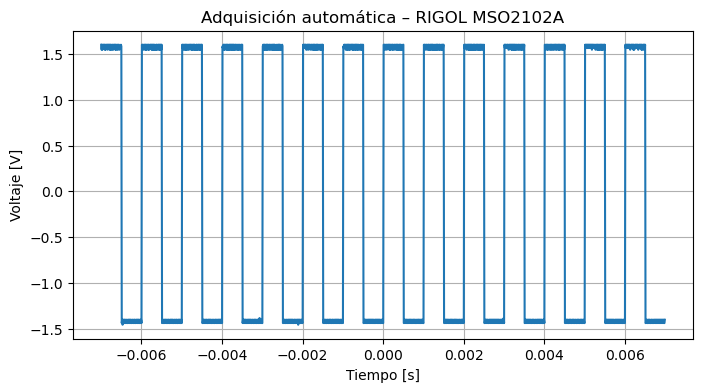

In [8]:
# Este método ejecuta la secuencia completa: conectar, configurar, adquirir y devolver datos
scope = Oscrigol("192.168.2.2")
scope.config(channels=(1,), vAutoScale=True)

data = scope()   # Abre, adquiere, deja RUN, no cierra conexión
print("Datos adquiridos:", data.shape)

# Graficar
t, v = data
plt.figure(figsize=(8,4))
plt.plot(t, v)
plt.title("Adquisición automática – RIGOL MSO2102A")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.grid(True)
plt.show()

scope.closeComm()


---

---

## TEST Continuous Reading

**Mode 1: Continuous Reading**
    
    - S1. :STOP Set the instrument to the STOP state (You can only read the waveform data in the internal memory when the oscilloscope is in the STOP state.)
    - S2. :WAV:SOUR CHAN1 Set the channel source of waveform data reading to CH1
    - S3. :WAV:MODE RAW Set the waveform data reading mode to RAW Note: When the channel source of waveform data reading is MATH or FFT, this mode is not available, and only the 2-364 MSO2000A/DS2000A Programming GuideRIGOL 2 Command System waveform data displayed on the screen can be read.
    - S4. :WAV:FORM BYTE Set the return format of the waveform data to BYTE
    - S5. :WAV:STAR 1 Set the start point of waveform data reading to the first waveform point
    - S6. :WAV:STOP 7000000 Set the stop point of waveform data reading to the 7000000th waveform point
    - S7. :WAV:RES Reset the waveform reading
    - S8. :WAV:BEG Start the waveform reading
    - S9. :WAV:STAT? Obtain the status of waveform data reading. If it returns IDLE,n, it indicates that waveform reading thread finishes, please execute S10; If it returns READ,n, it indicates that waveform reading thread is running, please execute S11.
    - S10. :WAV:DATA? Obtain data from the buffer :WAV:END Stop waveform reading The waveform reading is completed. Please combine in sequence the waveform data that are read separately.
    - S11. :WAV:DATA? Obtain data from the buffer 
    - Repeat S9

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from oscrigol import Oscrigol
import time

#scope.closeComm()

In [10]:
# Inicio comunicación
scope = Oscrigol("192.168.2.2")
scope.config(channels=(1,), vAutoScale=False)

scope.initComm()

scope._osci.timeout = 5000
scope.config(channels=(1,), vAutoScale=False)

In [11]:
osc_points=140000

In [12]:
scope._osci.query(":ACQ:SRAT?")
#time.sleep(2)
#scope._osci.read()

'5.00000e+07\n'

In [13]:
scope._osci.write(":ACQuire:MDEPth?")
time.sleep(2)
scope._osci.read()

'700000\n'

In [14]:
scope._osci.write(":WAVeform:STATus?")
time.sleep(2)
scope._osci.read()

'IDLE,0\n'

In [15]:
scope._osci.write(":ACQ:TYPE NORM")

16

In [16]:
scope._osci.write(":RUN")
scope._osci.write(f":ACQuire:MDEPth {osc_points}")

24

In [17]:
scope._osci.write(":ACQ:MDEPth?")
time.sleep(2)
scope._osci.read()

'700000\n'

In [18]:
scope._osci.write(":WAV:POIN?")
time.sleep(2)
scope._osci.read()

'1400\n'

In [19]:
scope._osci.write(":STOP")
scope._osci.write(":WAV:SOUR CHAN1")
scope._osci.write(":WAV:FORM BYTE")
scope._osci.write(":WAV:MODE RAW")
scope._osci.write(f":WAV:POIN {osc_points}")

18

In [20]:
scope._osci.write(":WAV:STAR 1")
scope._osci.write(f":WAV:STOP {osc_points}")
scope._osci.write(":WAV:RES")
scope._osci.write(":WAV:BEG")

10

In [21]:
# Validación número de puntos

ntps=0
# Consultar cantidad que realmente devolverá
npts = int(scope._osci.query(":WAVeform:POINts?"))
print("Cantidad de puntos disponibles (RAW):", npts)

Cantidad de puntos disponibles (RAW): 140000


In [22]:
preamble = scope._osci.query(":WAV:PRE?").split(',')
yinc = float(preamble[7])
yorig = float(preamble[8])
yref = float(preamble[9])

In [23]:
# Y1
from datetime import datetime
import numpy as np

print(datetime.now())
y_aux=[]
dataY=[]

while(len(dataY)<npts):
    raw = np.array(
        scope._osci.query_binary_values(":WAV:DATA?", datatype='B', container=np.array, chunk_size=npts)
    )
    y_aux = (raw - yref) * yinc + yorig
    dataY = np.append(dataY,y_aux)
    print(len(y_aux),y_aux)
    print(datetime.now())

print("-----------")
print("Final array")
print("-----------")
print(len(dataY),dataY)
print(datetime.now())

2025-11-04 09:02:44.239939
0 []
2025-11-04 09:02:44.256569
0 []
2025-11-04 09:02:44.299922
0 []
2025-11-04 09:02:44.320136
0 []
2025-11-04 09:02:44.340552
0 []
2025-11-04 09:02:44.371632
0 []
2025-11-04 09:02:44.413115
6041 [-1.41813048 -1.41813048 -1.41813048 ...  1.56357976  1.56357976
  1.56357976]
2025-11-04 09:02:44.615044
52224 [1.56357976 1.56357976 1.56357976 ... 1.56357976 1.56357976 1.56357976]
2025-11-04 09:02:46.239976
81735 [ 1.5453986   1.56357976  1.56357976 ... -1.43631164 -1.41813048
 -1.43631164]
2025-11-04 09:02:48.811537
-----------
Final array
-----------
140000 [-1.41813048 -1.41813048 -1.41813048 ... -1.43631164 -1.41813048
 -1.43631164]
2025-11-04 09:02:48.812923


In [24]:
# Datos eje X
preamble = scope._osci.query(":WAV:PRE?").split(',')
xinc = float(preamble[4])
xorig = float(preamble[5])
xref = float(preamble[6])
dataX = xorig + np.arange(len(dataY)) * xinc
print("xinc:",xinc)
print("xorig:",xorig)
print("xref:",xref)
print(len(dataX),dataX)
scope.closeComm()

xinc: 2e-08
xorig: -0.007
xref: 0.0
140000 [-0.007      -0.00699998 -0.00699996 ... -0.00420006 -0.00420004
 -0.00420002]


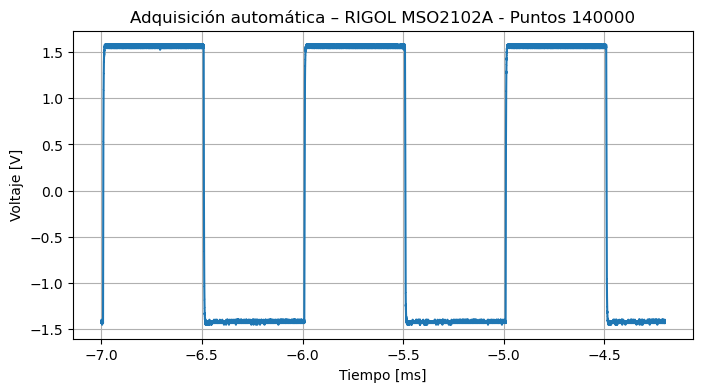

In [25]:
# Graficar
import matplotlib.pyplot as plt

t = dataX
v = dataY
plt.figure(figsize=(8,4))
plt.plot(t*1e3, v)
plt.title(f"Adquisición automática – RIGOL MSO2102A - Puntos {len(v)}")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Voltaje [V]")
plt.grid()
plt.show()

---

700000

700000

Transferencia RAW terminada en 22.1 s
Puntos decodificados: 140000
xinc: 2e-08
xorig: -0.007
xref: 0.0
699999 [-0.007      -0.00699998 -0.00699996 ...  0.00699992  0.00699994
  0.00699996]


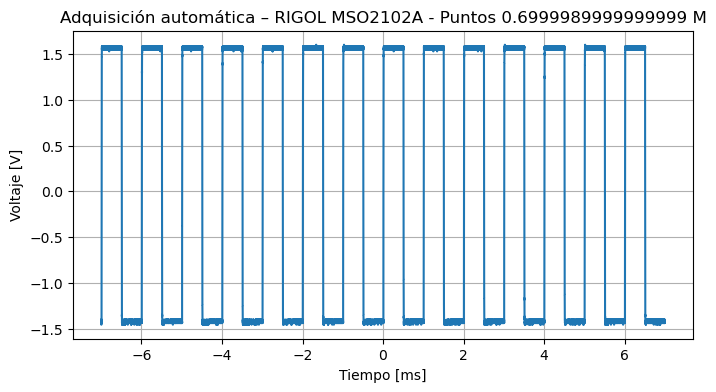

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from oscrigol import Oscrigol
import time
from datetime import datetime

# Inicio comunicación
if scope:
    scope.closeComm()

scope = Oscrigol("192.168.2.2")
scope.config(channels=(1,), vAutoScale=False)
scope.timeout = 5000

scope.initComm()

# Parametro adquisicon
osc_points=1400000 #14M

scope._osci.write(":ACQ:TYPE NORM")
scope._osci.write(":RUN")
scope._osci.write(f":ACQuire:MDEPth {osc_points}")

time.sleep(1)

scope._osci.write(":STOP")
scope._osci.write(":WAV:SOUR CHAN1")
scope._osci.write(":WAV:FORM BYTE")
scope._osci.write(":WAV:MODE RAW")
scope._osci.write(f":WAV:POIN {osc_points}")

scope._osci.write(":WAV:STAR 1")
scope._osci.write(f":WAV:STOP {osc_points}")
scope._osci.write(":WAV:RES")
scope._osci.write(":WAV:BEG")

time.sleep(1)

# check

scope._osci.write(":ACQ:MDEPth?")
time.sleep(2)
print(scope._osci.read())

scope._osci.write(":WAV:POIN?")
time.sleep(2)
print(scope._osci.read())


# Datos eje Y
preamble = scope._osci.query(":WAV:PRE?").split(',')
yinc = float(preamble[7])
yorig = float(preamble[8])
yref = float(preamble[9])


#print(datetime.now())
#y_aux=[]
#dataY=[]
#ind=0
#
#while(len(dataY)<osc_points):
#    raw = np.array(
#        scope._osci.query_binary_values(":WAV:DATA?", datatype='B', container=np.array, chunk_size=osc_points, delay=0.1)
#    )
#    y_aux = (raw - yref) * yinc + yorig
#    dataY = np.append(dataY,y_aux)
#    print("Ind:",ind,"Len:",datetime.now(),len(y_aux),y_aux)
#    ind=ind+1

#print("-----------")
#print("Final array")
#print("-----------")
#print(len(dataY),dataY)
#print(datetime.now())

t0 = time.time()
scope._osci.chunk_size = 2**20
scope._osci.timeout = 4*60*60

# Solicita la curva una sola vez
scope._osci.write(":WAV:DATA?")
raw = scope._osci.read_raw()
print(f"Transferencia RAW terminada en {time.time()-t0:.1f} s")

# Decodifica cabecera y datos
header_len = 2 + int(raw[1:2].decode())
data = raw[header_len+1:-1]  # quita #9header y LF
dataY = (np.frombuffer(data, dtype=np.uint8) - yref) * yinc + yorig

print("Puntos decodificados:", len(v))

# Datos eje X
preamble = scope._osci.query(":WAV:PRE?").split(',')
xinc = float(preamble[4])
xorig = float(preamble[5])
xref = float(preamble[6])
dataX = xorig + np.arange(len(dataY)) * xinc
print("xinc:",xinc)
print("xorig:",xorig)
print("xref:",xref)
print(len(dataX),dataX)
scope.closeComm()


t = dataX
v = dataY
plt.figure(figsize=(8,4))
plt.plot(t*1e3, v)
plt.title(f"Adquisición automática – RIGOL MSO2102A - Puntos {len(v)*1e-6} M")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Voltaje [V]")
plt.grid()
plt.show()

---
---

## TEST X – Adquisición 

El modo debe devolver MAXimum

getWaveformPointsCount() aprox 7000000

El gráfico resultante debe mostrar la señal con muchísima mayor resolución que los 1400 puntos del display.

---

## TEST RIGOL download_raw_data()

⚠️ Profundidad solicitada 1.5e+04 ajustada a 7.0e+03 (canales activos = 2)
:ACQ:MDEPth? =  7000

:WAV:POIN? =  7000

Descargando 7,000 puntos del canal 1...
Ind: 0 Len: 7000 [1.56357976 1.56357976 1.56357976 ... 1.07268844 1.43631164 1.52721744]
Transferencia completada en 0.3 s

Memoria efectiva: 7,000 puntos
Canales activos: 2


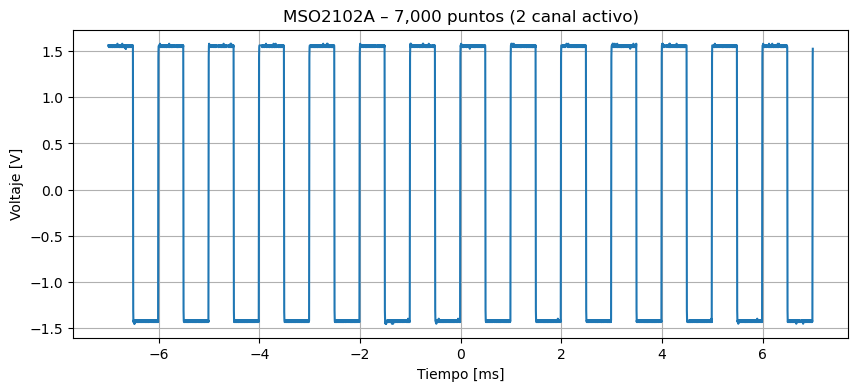

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from oscrigol import Oscrigol
import time
from datetime import datetime

# Inicio comunicación
scope=None

if scope:
    scope.closeComm()

scope = Oscrigol("192.168.2.2")
scope.config(channels=(1,), vAutoScale=False)
scope.timeout = 5000

scope.initComm()

t, v, mem_depth, nchan = scope.download_raw_data(channel=1, points=15_000)

scope.closeComm()

print(f"\nMemoria efectiva: {mem_depth:,} puntos")
print(f"Canales activos: {nchan}")


plt.figure(figsize=(10,4))
plt.plot(t*1e3, v)
plt.title(f"MSO2102A – {mem_depth:,} puntos ({nchan} canal activo)")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Voltaje [V]")
plt.grid(True)
plt.show()


## Benchmark pruebas de tiempo de ejecución para distintos MemDepth


=== BENCHMARK RIGOL MSO2102A – COMPARACIÓN 1 CH vs 2 CH ===


##### Ejecutando con 1 canal(es) activo(s) #####

--- Probando 1.4e+03 puntos ---
⚠️ Profundidad solicitada 1.4e+03 ajustada a 1.4e+04 (canales activos = 1)
:ACQ:MDEPth? =  14000

:WAV:POIN? =  14000

Descargando 14,000 puntos del canal 1...
Ind: 0 Len: 14000 [1.49085512 1.50903628 1.50903628 ... 1.39994932 1.4544928  1.47267396]
Transferencia completada en 0.5 s
✔ 14,000 puntos descargados en 4.61 s → 3.04 kB/s (1 canales activos)
--- Probando 1.4e+04 puntos ---
:ACQ:MDEPth? =  14000

:WAV:POIN? =  14000

Descargando 14,000 puntos del canal 1...
Ind: 0 Len: 14000 [1.47267396 1.49085512 1.49085512 ... 1.30904352 1.39994932 1.4544928 ]
Transferencia completada en 0.5 s
✔ 14,000 puntos descargados en 4.78 s → 2.93 kB/s (1 canales activos)
--- Probando 1.4e+05 puntos ---
:ACQ:MDEPth? =  140000

:WAV:POIN? =  140000

Descargando 140,000 puntos del canal 1...
Ind: 0 Len: 140000 [-1.47267396 -1.47267396 -1.4544928  ... -1.4726739

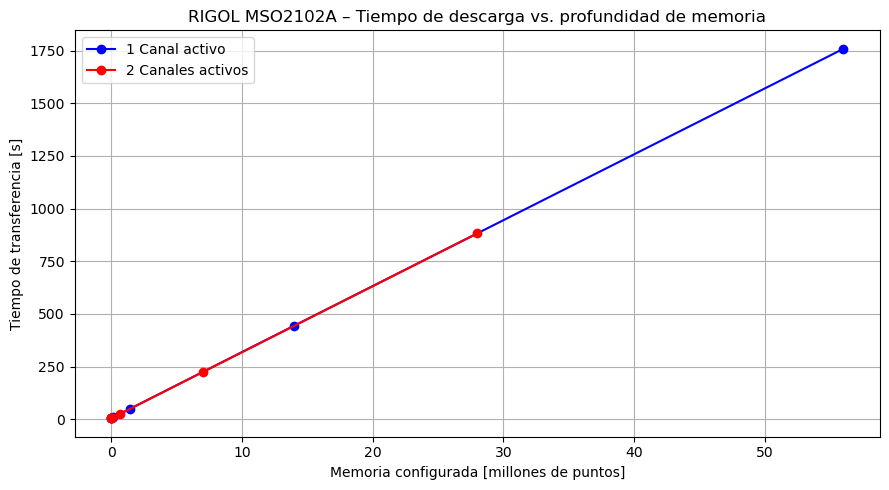

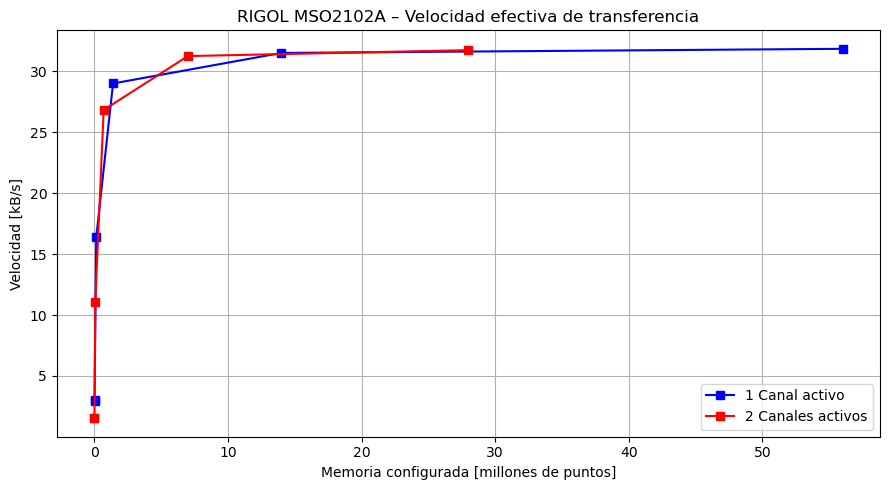

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import time
import csv
from oscrigol import Oscrigol
from datetime import datetime

# --- CONFIGURACIÓN ---
IP = "192.168.2.2"
CHANNEL = 1
CSV_OUT = "benchmark_mso2102a_full.csv"

# Profundidades válidas del manual (MSO/DS2000A)
VALID_DEPTHS = [1.4e3, 14e3, 140e3, 1.4e6, 14e6, 56e6]

# --- RESULTADOS ---
results = []

# --- CREAR OBJETO OSCILOSCOPIO ---
scope = Oscrigol(IP)
scope.initComm()
scope._osci.timeout = 120000
scope._osci.chunk_size = 2**20

print("\n=== BENCHMARK RIGOL MSO2102A – COMPARACIÓN 1 CH vs 2 CH ===\n")

# --- FUNCIÓN AUXILIAR ---
def run_benchmark(n_channels):
    """Ejecuta el benchmark con n_channels activos."""
    print(f"\n##### Ejecutando con {n_channels} canal(es) activo(s) #####\n")
    # Configurar visualización de canales
    scope._osci.write(":CHAN1:DISP ON")
    scope._osci.write(f":CHAN2:DISP {'ON' if n_channels == 2 else 'OFF'}")
    time.sleep(1)

    for pts in VALID_DEPTHS:
        try:
            print(f"--- Probando {pts:.1e} puntos ---")
            t0 = time.time()
            t, v, mem_depth, active_ch = scope.download_raw_data(channel=CHANNEL, points=pts)
            elapsed = time.time() - t0

            # Calcular velocidad de transferencia
            data_size_kB = len(v) / 1e3  # puntos ~ bytes en modo BYTE
            speed_kBps = data_size_kB / elapsed

            print(f"✔ {int(mem_depth):,} puntos descargados en {elapsed:.2f} s "
                  f"→ {speed_kBps:.2f} kB/s ({active_ch} canales activos)")

            results.append([mem_depth, len(v), elapsed, active_ch, speed_kBps])
        except Exception as e:
            print(f"❌ Error en {pts:.1e}: {e}")
        finally:
            time.sleep(2)

# --- BARRIDO 1 CANAL ---
run_benchmark(n_channels=1)

# --- BARRIDO 2 CANALES ---
run_benchmark(n_channels=2)

scope.closeComm()

# --- GUARDAR CSV ---
with open(CSV_OUT, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        "Memoria_configurada", "Puntos_descargados",
        "Tiempo_s", "Canales_activos", "Velocidad_kBps", "Fecha"
    ])
    for mem_depth, n, t_exec, nchan, v_kBps in results:
        writer.writerow([
            mem_depth, n, round(t_exec, 2),
            nchan, round(v_kBps, 3),
            datetime.now().isoformat()
        ])

print(f"\nResultados guardados en {CSV_OUT}")

# --- GRAFICAR RESULTADOS ---
mems_1ch = [r[0] for r in results if r[3] == 1]
times_1ch = [r[2] for r in results if r[3] == 1]
speed_1ch = [r[4] for r in results if r[3] == 1]

mems_2ch = [r[0] for r in results if r[3] == 2]
times_2ch = [r[2] for r in results if r[3] == 2]
speed_2ch = [r[4] for r in results if r[3] == 2]

plt.figure(figsize=(9,5))
plt.plot(np.array(mems_1ch)/1e3, times_1ch, 'o-b', label='1 Canal activo')
plt.plot(np.array(mems_2ch)/1e3, times_2ch, 'o-r', label='2 Canales activos')
plt.title("RIGOL MSO2102A – Tiempo de descarga vs. profundidad de memoria")
plt.xlabel("Memoria configurada [millones de puntos]")
plt.ylabel("Tiempo de transferencia [s]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,5))
plt.plot(np.array(mems_1ch)/1e3, speed_1ch, 's-b', label='1 Canal activo')
plt.plot(np.array(mems_2ch)/1e3, speed_2ch, 's-r', label='2 Canales activos')
plt.title("RIGOL MSO2102A – Velocidad efectiva de transferencia")
plt.xlabel("Memoria configurada [millones de puntos]")
plt.ylabel("Velocidad [kB/s]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
